# Conformal Prediction Models

The following is a demonstration of the conformal prediction models in Darts.

TLDR;

- Conformal prediction in Darts constructs valid prediction intervals without distributional assumptions.
- We use Split Conformal Prediction (SCP) due to its simplicity and efficiency.
- You can apply conformal prediction to any pre-trained global forecasting model.
- To improve your experience, our conformal models automatically extract the relevant calibration data from your input series required to generate the interval.
- We offer useful features to configure the extraction and make your conformal models more adaptive and efficient (`cal_length`, `cal_stride`).
- Conformal prediction supports all use cases (uni- and multivariate, single and multiple series, and single and multi-horizon forecasts, providing direct quantile value predictions or sampled predictions).
- We'll demonstrate how to use and evaluate conformal prediction on four examples using real-world data.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from darts import concatenate, metrics
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.models import ConformalNaiveModel, ConformalQRModel, LinearRegressionModel

## Conformal Prediction for Time Series Forecasting

*Conformal prediction is a technique for constructing prediction intervals that try to achieve valid coverage in finite samples, without making distributional assumptions.* [(source)](https://arxiv.org/pdf/1905.03222)

In other words: If we want a prediction interval that includes 80% of all actual values over some period of time, then a conformal model attempts to generate such intervals that actually have 80% of points inside.

There are different techniques to perform conformal prediction. In Darts, we currently use **Split Conformal Prediction [(SCP, Lei
et al., 2018)](https://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf)** (with some nice adaptions) due to its simplicity and efficiency. 

### Split Conformal Prediction
SCP adds calibrated prediction intervals with a specified confidence level to a base model's forecasts. It involves splitting the data into a training (+ optional validation) set and a calibration (+ test) set. The model is trained on the training set, and the calibration set is used to compute the prediction intervals to ensure they contain the true values with the desired probability.

#### Advantages

- **Valid Coverage**: Provides valid prediction intervals that are guaranteed to contain the true value with a specified confidence level on finite samples.
- **Model-agnostic**: Can be applied to any predictive model:
  - Either adds calibrated prediction intervals to point forecasting models
  - Or calibrates the predicted intervals in case of probabilistic forecasting models
- **Distribution-free**: No distributional assumptions about the data except that the errors on the calibration set are exchangeable (e.g. we don't need to assume that our data is normally distributed and then fit a model with a `GaussianLikelihood`).
- **Efficient**: Split Conformal Prediction is efficient since it does not require model re-training.
- **Interpretable**: The method is interpretable due to its simplicity.
- **Useful Applications**: It's used to provide more reliable and informative predictions to help decision-making in several industries. See this [article on conformal prediction](https://medium.com/@data-overload/conformal-prediction-a-critic-to-predictive-models-27501dcc76d4)

#### Disadvantages

- **Requires a Calibration Set**: Conformal prediction requires another data / hold-out set that is used solely to compute the calibrated prediction intervals. This can be inefficient for small datasets.
- **Exchangeability of Calibration Data** (a): The accuracy of the prediction intervals depends on the representativeness of the calibration data (or rather the forecast errors produced on the calibration set). The coverage is not guaranteed anymore if there is a **distribution shift** in forecast errors (e.g. series with a trend but forecasting model is not able to predict the trend).
- **Conservativeness** (a): May produce wider intervals than necessary, leading to conservative predictions.

(a) Darts conformal models have some parameters to control the extraction of the calibration set for more adaptiveness (see more infos [here](#Darts-features-to-make-your-Conformal-Models-more-adaptive)).

## Darts Conformal Models

Darts' conformal models add calibrated prediction intervals to the forecasts of any **pre-trained global forecasting model**. 
There is no need to train the conformal models themselves (e.g. no `fit()` required) and you can directly call `predict()` or `historical_forecasts()`. Behind the hood, Darts will automatically extract the calibration set from the past of your input series and use it to generate the calibrated prediction intervals (see [here](#Workflow-behind-the-hood) for more detail).

> **Important**: The `series` passed to the forecast methods **should not have any overlap** with the series used to **train** the forecasting model, since this will lead to overly optimistic prediction intervals.

### Model support

All conformal models in Darts support:

- any **pre-trained global forecasting model** as the base forecaster (you can find a list [here](https://unit8co.github.io/darts/#forecasting-models))
- **uni-** and **multivariate** forecasts (single / multi-columns)
- **single** and **multiple series** forecasts
- **single** and **multi-horizon** forecasts
- generate a **single** or **multiple calibrated prediction intervals**
- **direct quantile value** predictions (interval bounds) or **sampled predictions** from these quantile values
- **any covariates** based on the underlying forecasting model

### Direct Interval Predictions or Sampled Predictions
Conformal models are probabilistic, so you can forecast in two ways (when calling `predict()`, `historical_forecasts()`, ...):

- Forecast the calibrated quantile interval bounds directly (example [here](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Direct-Parameter-Predicitons)).
  - `predict(..., predict_likelihood_parameters=True)`
- Generate stochastic forecasts by sampling from these calibrated quantile intervals (examples [here](https://unit8co.github.io/darts/quickstart/00-quickstart.html#Probabilistic-Sample-Predictions)):
  - `predict(..., num_samples=1000)`

### Workflow behind the hood

> Note: `cal_length` and `cal_stride` will be further explained [below](#Darts-features-to-make-your-Conformal-Models-more-adaptive).

In general, the workflow of the models to produce one calibrated forecast/prediction is as follows (using `predict()`):

- **Extract a calibration set**: The calibration set for each conformal forecast is automatically extracted from
  the most recent past of your input series relative to the forecast start point. The number of calibration examples
  (forecast errors / non-conformity scores) to consider can be defined at model creation
  with parameter `cal_length`. Note that when using `cal_stride>1`, a longer history is required since
  the calibration examples are generated with stridden historical forecasts.
- Generate **historical forecasts** on the calibration set (using the forecasting model) with a stride `cal_stride`.
- Compute the **errors/non-conformity scores** (specific to each conformal model) on these historical forecasts
- Compute the **quantile values** from the errors / non-conformity scores (using our desired quantiles set at model
  creation with parameter `quantiles`).
- Compute the conformal prediction: Using these quantile values, add **calibrated intervals** to (or adjust the
  existing intervals of) the forecasting model's predictions.

For **multi-horizon forecasts**, the above is applied for each step in the horizon separately.

When computing `historical_forecasts()`, `backtest()`, `residuals()`, ... the above is applied for each forecast (the forecasting model's historical forecasts are only generated once for efficiency).

### Available Conformal Models

At the time of writing (Darts version 0.32.0), we have two conformal models:

#### `ConformalNaiveModel`

Adds calibrated intervals around the median forecast of **any pre-trained global forecasting model**. It supports two symmetry modes:

- `symmetric=True`:
    - The lower and upper interval bounds are calibrated with the same magnitude.
    - Non-conformity scores: uses the [absolute error](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.ae) `ae()` to compute the non-conformity scores on the calibration set.
- `symmetric=False`
    - The lower and upper interval bounds are calibrated separately.
    - Non-conformity scores: uses the [error](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.err) `err()` to compute the
      non-conformity scores on the calibration set for the upper bounds, and `-err()` for the lower bounds.

#### `ConformalQRModel` (Conformalized Quantile Regression Model)

Calibrates the quantile predictions of a **pre-trained probabilistic global forecasting model**. It supports two symmetry modes:

- `symmetric=True`:
    - The lower and upper quantile predictions are calibrated with the same magnitude.
    - Non-conformity scores: uses the [Non-Conformity Score for Quantile Regression](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.incs_qr) `incs_qr(symmetric=True)` on the calibration set.
- `symmetric=False`
    - The lower and upper quantile predictions are calibrated separately.
    - Non-conformity scores: uses the [Asymmetric Non-Conformity Score for Quantile Regression](https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html#darts.metrics.metrics.incs_qr) `incs_qr(symmetric=False)` for the upper and lower bound on the calibration set.

### Darts features to make your Conformal Models more adaptive

As mentioned in [Split Conformal Prediction - Disadvantages](#Disadvantages), the calibration set has a large impact on the effectiveness of our conformal prediction technique.

We implemented some cool features to make our automatic extraction of the calibration set even more powerful for you.

All our conformal models have the following two parameters at model creation:

- `cal_length`: The number of non-conformity scores (NCS) in the most recent past to use as calibration for each conformal forecast (and each step in the horizon).
  -  If `None` acts as an expanding window mode
  -  If `>=1` uses a moving fixed-length window mode
  -  Benefits:
      -  Using `cal_length` makes your model react more quickly to distribution shifts in NCS.
      -  Using `cal_length` reduces the computational cost to perform the calibration.
  -  Caution: Use large enough values to have enough example for calibration.
- `cal_stride`: (default=1) The stride (number of time steps between two consecutive forecasts) to apply when computing the historical forecasts and non-conformity scores on the calibration set.
  - This is useful if we want to run our models on a scheduled basis (e.g. once every 24 hours) and are only interested in the NCS that were produced on this schedule.
  - Caution: `cal_stride>1` requires a longer `series` history (roughly `cal_length * stride` points).

## Examples

We will show four examples:

1) How to perform conformal prediction and compare different models based on the quantified uncertainty. For simplicity, we will use a single step horizon `n=1`.
2) How to perform multistep horizon conformal forecasts
3) How to perform multistep horizon conformal forecasts on a scheduled basis
4) An example of conformalized quantile regression.

### Input Dataset
For both examples, we use the Electricity Consumption Dataset from households in Zurich, Switzerland.

The dataset has a quarter-hourly frequency (15 Min time intervals), but we resample it to hourly frequency to keep things simple.

To keep it simple, we will not use any covariates and only concentrate on the electricity consumption as the target we want to predict. The conformal model's covariate support and API is identical to the base-forecaster.

**Target series** (the series we want to forecast):
- **Value_NE5**: Electricity consumption by households on grid level 5 (in kWh).

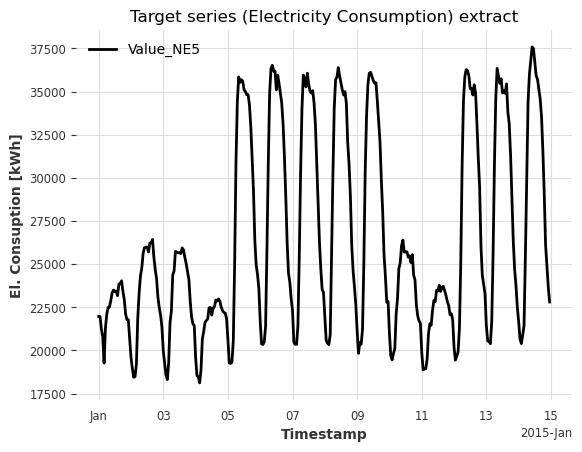

In [3]:
series = ElectricityConsumptionZurichDataset().load().astype(np.float32)

# extract target and resample to hourly frequency
series = series["Value_NE5"].resample(freq="h")

# plot 2 weeks of hourly consumption
ax = series[: 2 * 7 * 24].plot()
ax.set_ylabel("El. Consuption [kWh]")
ax.set_title("Target series (Electricity Consumption) extract");

Extract a train, calibration and test set. Note that `cal` does not overlap with the training set `train`.

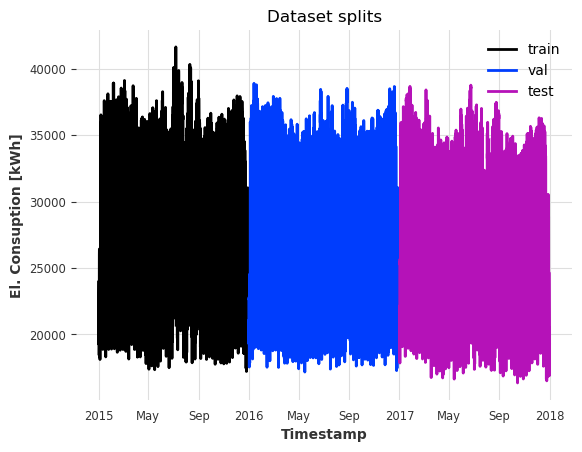

In [4]:
train_start = pd.Timestamp("2015-01-01")
cal_start = pd.Timestamp("2016-01-01")
test_start = pd.Timestamp("2017-01-01")
test_end = pd.Timestamp("2018-01-01")

train = series[train_start : cal_start - series.freq]
cal = series[cal_start : test_start - series.freq]
test = series[test_start:test_end]

ax = train.plot(label="train")
cal.plot(label="val")
test.plot(label="test")

ax.set_ylabel("El. Consuption [kWh]")
ax.set_title("Dataset splits");

### Example 1: Compare different models on single step horizon forecasts

Let's see how we can use conformal prediction in Darts. We'll show how to:

- use conformal prediction (predict and historical forecasts)
- evaluate the prediction intervals (simple prediction and backtest).
- compare two different base forecasting models using conformal prediction.

To demonstrate the process, we focus first only on one base forecasting model.

#### Train the base forecaster

Let's use a `LinearRegressionModel` as our base forecasting model. We configure it to use the last two hours as lookback to forecast the next hour (single step horizon; multi horizon will be covered in Example 2).

- train it on the `train` set
- forecast the next hour after the end of the `cal` set

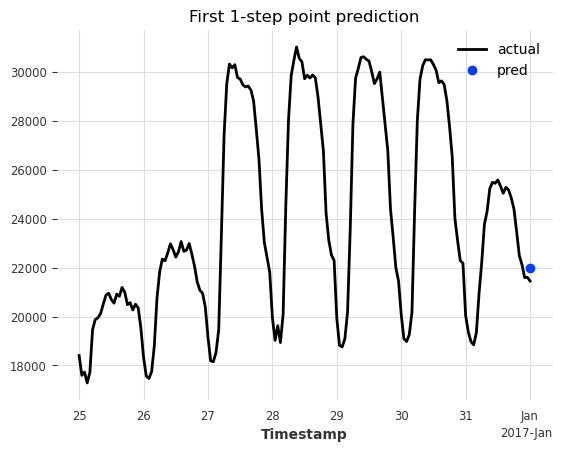

In [5]:
horizon = 1

# train the model
model = LinearRegressionModel(lags=2, output_chunk_length=horizon)
model.fit(train)

# forecast
pred = model.predict(n=horizon, series=cal)

# plot
ax = series[pred.start_time() - 7 * 24 * series.freq : pred.end_time()].plot(
    label="actual"
)
pred.plot(label="pred")
ax.set_title("First 1-step point prediction");

Great, we have our single step forecast. But without knowing the actual target value at that time, we wouldn't have any estimate of the uncertainty.

#### Apply Conformal Prediction

Now let's apply conformal prediction to quantify the uncertainty. We use the symmetric (default) naive model, including the quantile levels we want to forecast. Also:

- we don't need to train / fit the conformal model
- we should supply a `series` to `predict()` that does not have an overlap with the series used to train the model. In our case `cal` has no overlap with `train`.
- the API is identical to Darts' forecasting models.

Let's configure the conformal model:
- add a 90% quantile interval (quantiles 0.05 - 0.95) (`quantiles`).
- consider only the last 4 weeks of non-conformity scores to calibrate the prediction intervals (`cal_length`).

> Note: you can add any number of intervals, e.g. `[0.10, 0.20, 0.50, 0.80, 0.90]` would add the 80% (0.10 - 0.90) and 60% (0.20 - 0.80) intervals

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

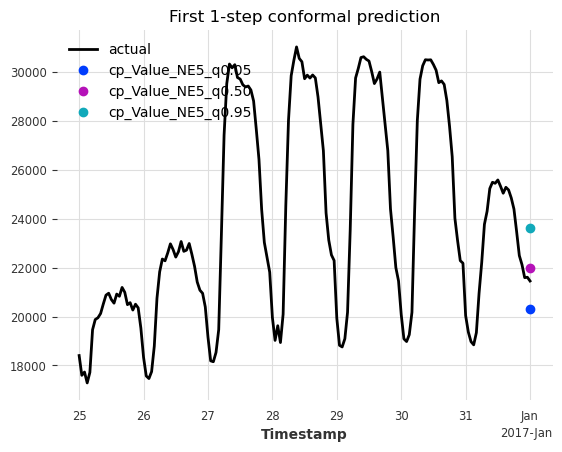

In [6]:
quantiles = [0.05, 0.50, 0.95]
four_weeks = 4 * 7 * 24
pred_kwargs = {"predict_likelihood_parameters": True, "verbose": True}

# create conformal model
cp_model = ConformalNaiveModel(model=model, quantiles=quantiles, cal_length=four_weeks)

# conformal forecast
pred = cp_model.predict(n=horizon, series=cal, **pred_kwargs)

# plot
ax = series[pred.start_time() - 7 * 24 * series.freq : pred.end_time()].plot(
    label="actual"
)
pred.plot(label="cp")
ax.set_title("First 1-step conformal prediction");

Great, we can see the added prediction interval (turquoise, dark blue) around the base model's forecast (purple).
It's clear that the predicted interval contains the actual value. Let's look at how to evaluate this forecast.

#### Evaluate Conformal Prediction

Darts has dedicated metrics for prediction intervals. You can find them on [our metrics page](https://unit8co.github.io/darts/generated_api/darts.metrics.html) under the *Quantile interval metrics*. You can use them as standalone metrics or for backtesting.

- `(m)ic`: (Mean) Interval Coverage
- `(m)iw`: (Mean) Interval Width
- `(m)iws`: (Mean) Interval Winkler Score
- `(m)incs_qr`: (Mean) Interval Non-Conformity Score for Quantile Regression

> Note: for `backtest()` use the (m)ean metrics such as `mic()`, and for `residuals()` the per-time step metrics such as `ic()`.

Let's check the interval coverage (the ratio of actual values being within each interval) and the interval width:

In [7]:
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]


def compute_metrics(pred_):
    mic = metrics.mic(series, pred_, q_interval=q_interval)
    miw = metrics.miw(series, pred_, q_interval=q_interval)
    return pd.DataFrame({"Interval": q_range, "Coverage": mic, "Width": miw}).round(2)


compute_metrics(pred)

,Interval,Coverage,Width
0,0.9,1.0,3321.12


Okay, we see an interval width of 3.3 MWh, and a coverage of 100%. We would expect a coverage of 90% (on finite samples). But so far we've only looked at 1 example. How does it perform on the entire test set?

In [8]:
# concatenate cal and test set to be able to start forecasting at the `test` start time
cal_test = concatenate([cal, test], axis=0)

hfcs = cp_model.historical_forecasts(
    series=cal_test,
    forecast_horizon=horizon,
    start=test.start_time(),
    last_points_only=True,  # returns a single TimeSeries
    **pred_kwargs,
)

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/8761 [00:00<?, ?it/s]

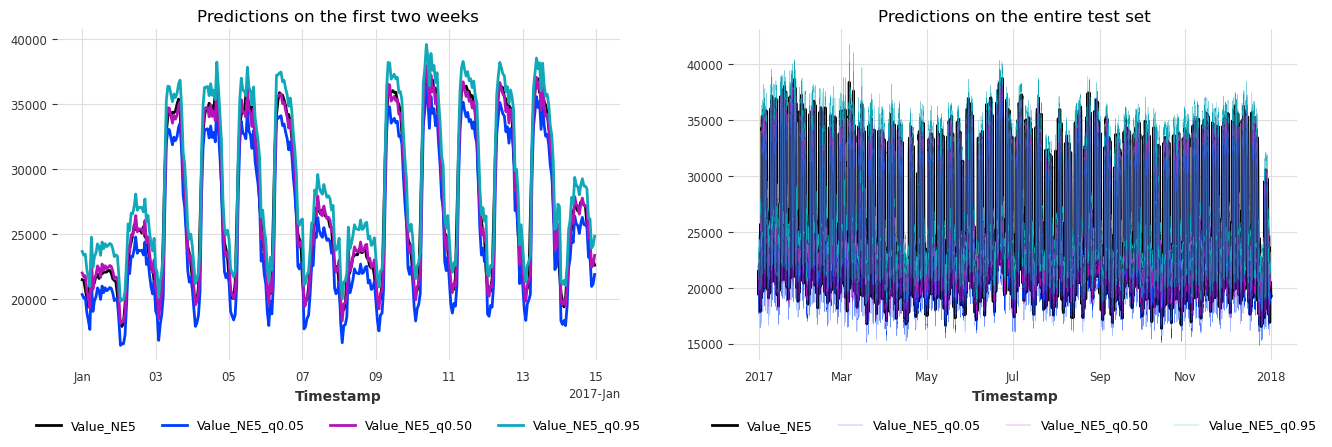

In [9]:
def plot_historical_forecasts(hfcs_):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4.3))
    test[: 2 * 7 * 24].plot(ax=ax1)
    hfcs_[: 2 * 7 * 24].plot(ax=ax1)
    ax1.set_title("Predictions on the first two weeks")
    ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=9)

    test.plot(ax=ax2)
    hfcs_.plot(ax=ax2, lw=0.2)
    ax2.set_title("Predictions on the entire test set")
    ax2.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=9)


plot_historical_forecasts(hfcs)

Nice, we just performed a one-year simulation of applying conformal prediction in under 1 second! The intervals also seem to be well calibrated.
Let's find out by computing the metrics on all historical forecasts (backtest).

In [10]:
bt = cp_model.backtest(
    cal_test,
    historical_forecasts=hfcs,
    last_points_only=True,
    metric=[metrics.mic, metrics.miw],
    metric_kwargs={"q_interval": q_interval},
)
bt = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1]})
bt

,Interval,Coverage,Width
0,0.9,0.901609,2908.944092


Great! Our interval indeed covers 90% of all actual values. The mean width / uncertainty range is just under 3MWh.

It would also be interesting to see how the coverage and widths behaved over time.

The coverage metric `ic()` gives a binary value for each time step (whether the interval contains the actual). To get the coverage ratios over some period of time, we compute the moving average with a window of 4 weeks.

In [11]:
def compute_moving_average_metrics(hfcs_, metric=metrics.ic):
    """Computes the moving 4-week average of a specific time-dependent metric."""
    # compute metric on each time step
    residuals = cp_model.residuals(
        cal_test,
        historical_forecasts=hfcs_,
        last_points_only=True,
        metric=metric,
        metric_kwargs={"q_interval": q_interval},
    )

    # let's apply a moving average to the residuals with a winodow of 4 weeks
    windowed_residuals = residuals.window_transform(
        transforms={"function": "mean", "mode": "rolling", "window": four_weeks}
    )
    return windowed_residuals

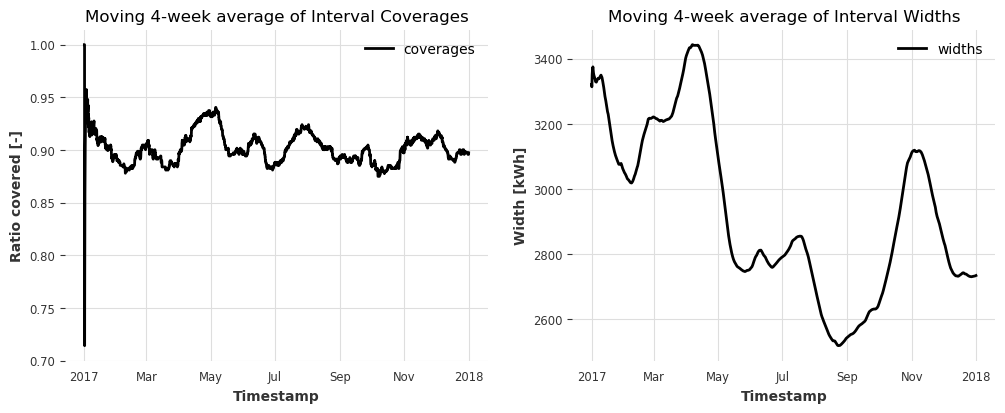

In [12]:
covs = compute_moving_average_metrics(hfcs, metrics.ic)
widths = compute_moving_average_metrics(hfcs, metrics.iw)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4.3))
covs.plot(ax=ax1, label="coverages")
ax1.set_ylabel("Ratio covered [-]")
ax1.set_title("Moving 4-week average of Interval Coverages")

widths.plot(ax=ax2, label="widths")
ax2.set_ylabel("Width [kWh]")
ax2.set_title("Moving 4-week average of Interval Widths");

Also here, the coverage looks stable around 90% over the entire year -> the conformal model is valid.

The interval widths range from 2.5 - 3.5 MWh. The adaptivity/responsiveness of the widths to changes in model performance is mainly controlled by the value of `cal_length`.

#### Comparison with another model

Okay now let's compare the uncertainty of our first model with a more powerful regression model.

- Use the last week (7*24) of consumption as lookback window
- Also use a cyclic encoding of the hour of the day and day of week as a future covariate

The process is exactly the same as for the first model, so we won't go into any detail.

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/8761 [00:00<?, ?it/s]

,Interval,Coverage,Width
0,0.9,0.898413,1662.243896


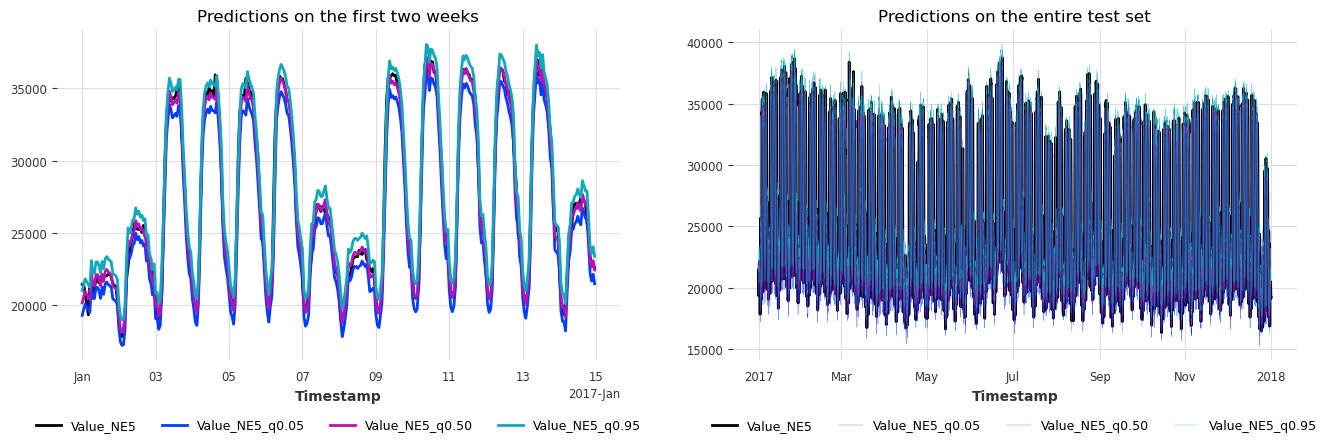

In [13]:
add_encoders = {"cyclic": {"future": ["hour", "dayofweek"]}}
input_length = 7 * 24
model2 = LinearRegressionModel(
    lags=input_length,
    lags_future_covariates=(input_length, 1),
    output_chunk_length=1,
    add_encoders=add_encoders,
)
model2.fit(train)

cp_model2 = ConformalNaiveModel(
    model=model2, quantiles=quantiles, cal_length=four_weeks
)
hfcs2 = cp_model2.historical_forecasts(
    series=cal_test,
    forecast_horizon=horizon,
    start=test.start_time(),
    last_points_only=True,
    stride=horizon,
    **pred_kwargs,
)
plot_historical_forecasts(hfcs2)

bt2 = cp_model.backtest(
    cal_test,
    historical_forecasts=hfcs2,
    last_points_only=True,
    metric=[metrics.mic, metrics.miw],
    metric_kwargs={"q_interval": q_interval},
)
bt2 = pd.DataFrame({"Interval": q_range, "Coverage": bt2[0], "Width": bt2[1]})
bt2

Nice! We achieve again 90% coverage, but our average **interval width decreased from 2.9 MWh to 1.7 MWh!**
Finally, let's also look at the metrics over time and compare our two models.

,Interval,Coverage,Width
Model 1,0.9,0.902,2908.944
Model 2,0.9,0.898,1662.244


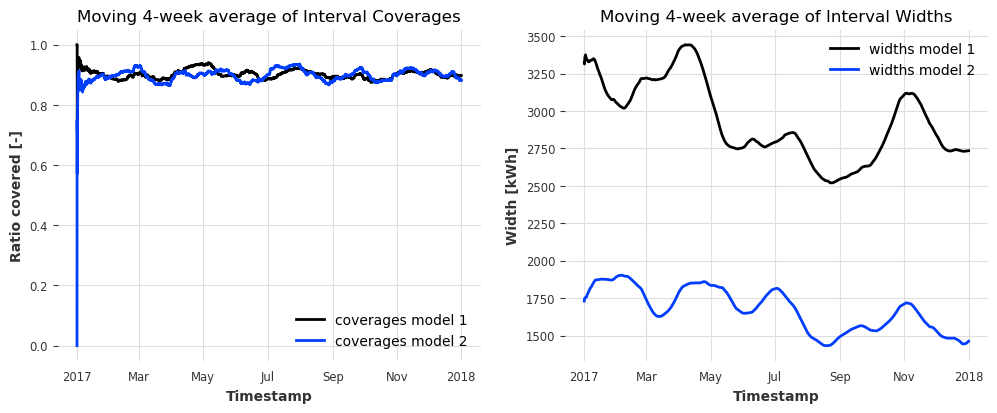

In [14]:
covs2 = compute_moving_average_metrics(hfcs2, metrics.ic)
widths2 = compute_moving_average_metrics(hfcs2, metrics.iw)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4.3))
covs.plot(ax=ax1, label="coverages model 1")
covs2.plot(ax=ax1, label="coverages model 2")
ax1.set_ylabel("Ratio covered [-]")
ax1.set_title("Moving 4-week average of Interval Coverages")

widths.plot(ax=ax2, label="widths model 1")
widths2.plot(ax=ax2, label="widths model 2")
ax2.set_ylabel("Width [kWh]")
ax2.set_title("Moving 4-week average of Interval Widths")

bts = pd.concat([bt, bt2], axis=0).round(3)
bts.index = ["Model 1", "Model 2"]
bts

Stable coverage over time for both models, but consistently lower interval widths for Model 2 -> we can clearly say that Model 2 is the winner (through **lower uncertainty**).

### Example 2: Multi-horizon forecasts

Multi-horizon forecasts are supported out of the box. Simply set `n>1` (or `forecast_horizon`), and the model generates calibrated prediction intervals for each step.

historical forecasts:   0%|          | 0/696 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Timestamp'>

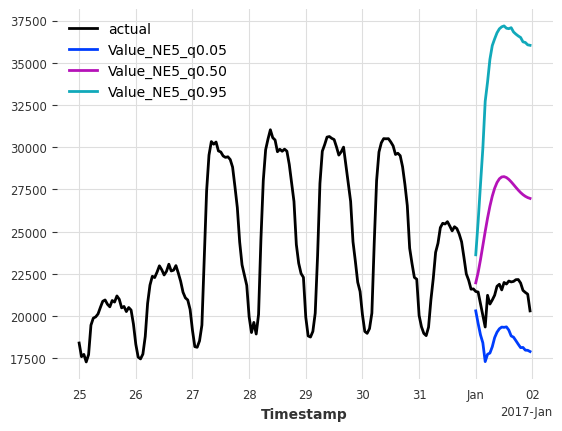

In [15]:
multi_horizon = 24
pred = cp_model.predict(n=multi_horizon, series=cal, **pred_kwargs)

# plot
ax = series[pred.start_time() - 7 * 24 * series.freq : pred.end_time()].plot(
    label="actual"
)
pred.plot()

Oh, why do we have such large intervals now? It's because we used Model 1 (the worse one) that was trained to predict only the next hour. Then under the hood we perform auto-regression to generate the 24-hour forecasts on the calibration set. Consequently, this results in larger errors / non-conformity scores the further ahead we predict, and ultimately in higher model uncertainty.

We can perform much better if we use a base-forecaster that was trained on predicting the next 24 hours directly:

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='Timestamp'>

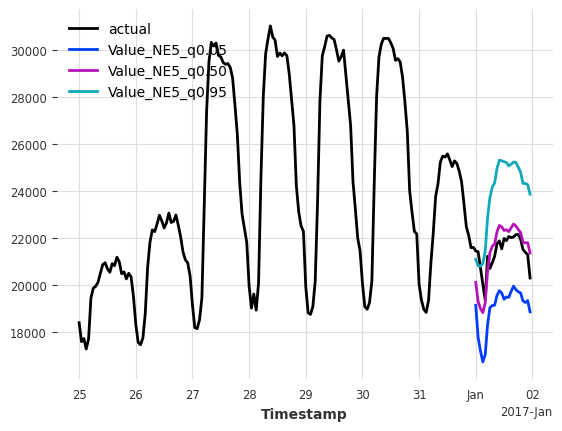

In [16]:
multi_horizon = 24

model = LinearRegressionModel(lags=input_length, output_chunk_length=multi_horizon).fit(
    train
)
cp_model = ConformalNaiveModel(model=model, quantiles=quantiles, cal_length=four_weeks)

pred = cp_model.predict(n=multi_horizon, series=cal, **pred_kwargs)

# plot
ax = series[pred.start_time() - 7 * 24 * series.freq : pred.end_time()].plot(
    label="actual"
)
pred.plot()

### Example 3: Multi-horizon Forecasts on a Scheduled Basis with valid Coverage

But what if we want to apply multi-horizon forecasts on a scheduled basis?

E.g. we want to make a one-day (24 hour) forecast every 24 hours.

By default, the calibration set considers all possible historical forecasts on the calibration set (`cal_stride=1`).
This would use examples generated outside our 24-hour schedule, and might lead to invalid coverages.

Setting `cal_stride=24` will extract the correct examples.

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/365 [00:00<?, ?it/s]

,Interval,Coverage,Width
0,0.9,0.902283,4772.75975


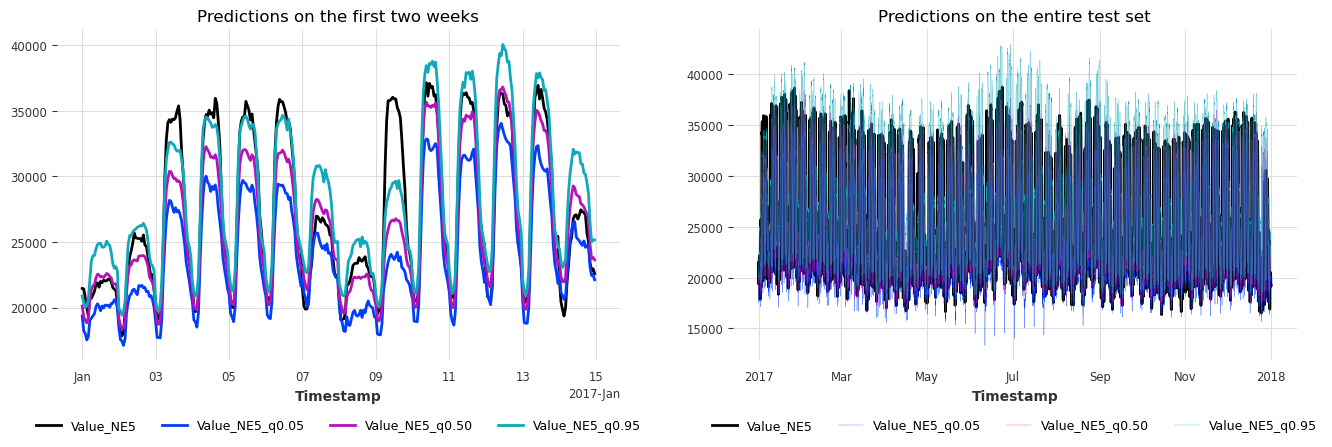

In [17]:
# conformal model
cp_model = ConformalNaiveModel(
    model=model,
    quantiles=quantiles,
    cal_length=100,
    cal_stride=multi_horizon,  # stride for calibration set
)

hfcs = cp_model.historical_forecasts(
    series=cal_test,
    forecast_horizon=multi_horizon,
    start=test.start_time(),
    last_points_only=False,  # return each multi-horizon forecast
    stride=multi_horizon,  # use the same stride for historical forecasts
    **pred_kwargs,
)

# concatenate the forecasts into a single TimeSeries
hfcs_concat = concatenate(hfcs, axis=0)
plot_historical_forecasts(hfcs_concat)

bt = cp_model.backtest(
    cal_test,
    historical_forecasts=hfcs,
    last_points_only=False,
    metric=[metrics.mic, metrics.miw],
    metric_kwargs={"q_interval": q_interval},
)
pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1]})

Great, we also achieve valid coverage when applying our model only once per day.

Since we have multi-horizon forecasts, it's also important to check the coverage and width for each step in the horizon:

In [18]:
def compute_hfc_horizon_metric(metric=metrics.ic):
    # computes the metric per historical forecast, horizon and component with
    # shape `(n forecasts, horizon, n components, 1)`
    residuals = cp_model.residuals(
        cal_test,
        historical_forecasts=hfcs,
        last_points_only=False,
        metric=metric,
        metric_kwargs={"q_interval": q_interval},
        values_only=True,
    )
    # create array and drop component and sample axes
    residuals = np.array(residuals)[:, :, 0, 0]

    # compute the mean over all forecasts (365 1-day forecasts) for each horizon
    return np.mean(residuals, axis=0)


covs_horizon = compute_hfc_horizon_metric(metrics.ic)
widths_horizon = compute_hfc_horizon_metric(metrics.iw)

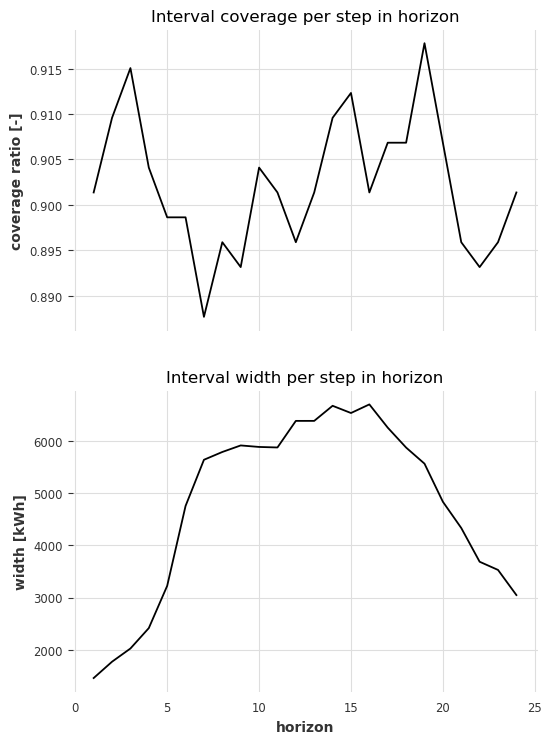

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 8.6), sharex=True)

horizons = [i + 1 for i in range(24)]
ax1.plot(horizons, covs_horizon)
ax2.plot(horizons, widths_horizon)

ax1.set_ylabel("coverage ratio [-]")
ax1.set_title("Interval coverage per step in horizon")

ax2.set_xlabel("horizon")
ax2.set_ylabel("width [kWh]")
ax2.set_title("Interval width per step in horizon");

The coverages are valid for all steps in the horizon and range between 89% and 92%.

In general, the widths increase with higher horizon. After horizon 16 they drop again, due to the nature of the target series (low Electricity consumption during the night -> lower uncertainty.)

### Example 4: Conformalized Quantile Regression

Finally, let's check out an example of our `ConformalQRModel`. The API is exactly the same. 

The only difference is that it requires a **probabilistic** base forecaster.

Let's use a linear model with quantile regression and perform the same single step forecast as in example 1.

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/8761 [00:00<?, ?it/s]

,Interval,Coverage,Width
0,0.9,0.90024,1770.154514


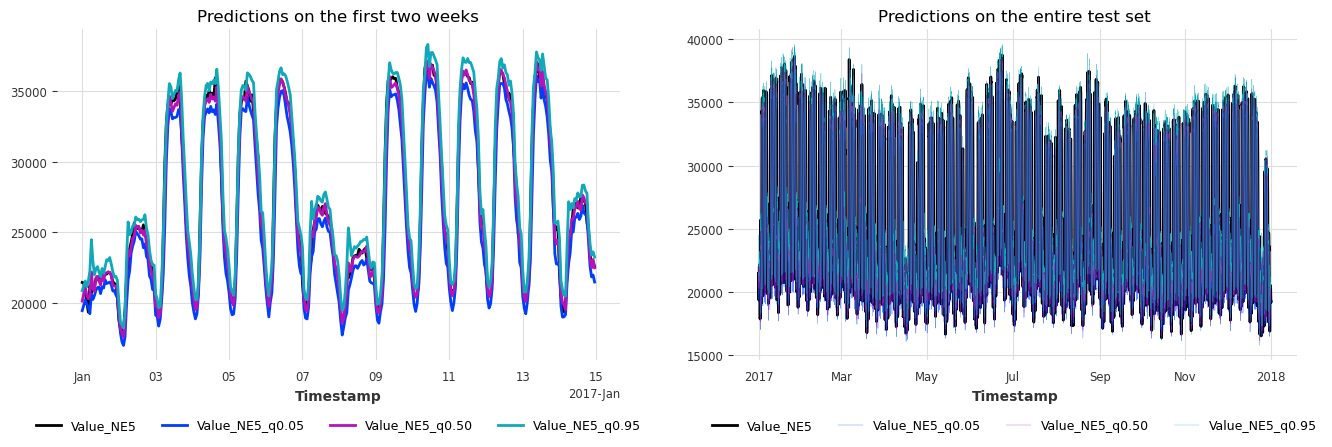

In [20]:
# probabilistic regression model (with quantiles)
model = LinearRegressionModel(
    lags=input_length,
    output_chunk_length=horizon,
    likelihood="quantile",
    quantiles=quantiles,
).fit(train)

# conformalized quantile regression model
cp_model = ConformalQRModel(model=model, quantiles=quantiles, cal_length=four_weeks)
hfcs = cp_model.historical_forecasts(
    series=cal_test,
    forecast_horizon=horizon,
    start=test.start_time(),
    last_points_only=True,
    stride=horizon,
    **pred_kwargs,
)
plot_historical_forecasts(hfcs)

bt = cp_model.backtest(
    cal_test,
    historical_forecasts=hfcs,
    last_points_only=True,
    metric=[metrics.mic, metrics.miw],
    metric_kwargs={"q_interval": q_interval},
)
pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1]})

Same coverage, but slightly larger intervals than in the naive conformal prediction case.